# Association Rule Mining on Philippine Earthquake Clusters


## Import Libraries

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder

## Initial Data Exploration

In [4]:
df = pd.read_csv("../dataset/phivolcs_earthquake_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118955 entries, 0 to 118954
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_Time_PH       118955 non-null  object 
 1   Latitude           118931 non-null  float64
 2   Longitude          118931 non-null  float64
 3   Depth_In_Km        118954 non-null  object 
 4   Magnitude          118955 non-null  float64
 5   Location           118955 non-null  object 
 6   Specific_Location  118955 non-null  object 
 7   General_Location   118955 non-null  object 
dtypes: float64(3), object(5)
memory usage: 7.3+ MB


In [5]:
df.describe()

,Latitude,Longitude,Magnitude
count,118931.000000,118931.000000,118955.000000
mean,10.903026,124.056514,2.509793
std,3.977757,2.544317,0.701736
min,1.730000,10.560000,1.000000
25%,7.920000,121.420000,2.000000
50%,9.970000,124.870000,2.400000
75%,13.750000,126.270000,2.900000
max,24.840000,163.630000,7.500000


In [6]:
df.head()

,Date_Time_PH,Latitude,Longitude,Depth_In_Km,Magnitude,Location,Specific_Location,General_Location
0,2025-12-13 10:42:00,7.62,127.04,15.0,3.1,054 km N 85° E of Baganga (Davao Oriental),Baganga,Davao Oriental
1,2025-12-13 10:16:00,12.86,123.53,5.0,2.1,009 km S 56° W of Donsol (Sorsogon),Donsol,Sorsogon
2,2025-12-13 10:01:00,7.54,126.74,28.0,4.5,020 km S 79° E of Baganga (Davao Oriental),Baganga,Davao Oriental
3,2025-12-13 09:55:00,10.98,123.89,33.0,2.1,012 km S 52° W of City Of Bogo (Cebu),City Of Bogo,Cebu
4,2025-12-13 08:38:00,14.14,120.02,127.0,1.7,033 km N 20° W of Lubang (Occidental Mindoro),Lubang,Occidental Mindoro


### Checking for duplicates

In [7]:
# Count total duplicate rows
count_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {count_duplicates}")


Number of duplicate rows: 0


### 1. Dropping rows with missing values

In [8]:
df.isnull().sum()

Date_Time_PH          0
Latitude             24
Longitude            24
Depth_In_Km           1
Magnitude             0
Location              0
Specific_Location     0
General_Location      0
dtype: int64

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

Date_Time_PH         0
Latitude             0
Longitude            0
Depth_In_Km          0
Magnitude            0
Location             0
Specific_Location    0
General_Location     0
dtype: int64

### 2. Limiting data from 2019 to 2025

In [11]:
df['Date_Time_PH'] = pd.to_datetime(df['Date_Time_PH'])

'''
    Filtering dataset from 2019 to 2025
'''
start_date = '2019-01-01'
end_date = '2025-12-31' 
df = df[(df['Date_Time_PH'] >= start_date) & (df['Date_Time_PH'] <= end_date)]

print(f"Dataset filtered (2019-2025). New row count: {len(df)}")

Dataset filtered (2019-2025). New row count: 110350


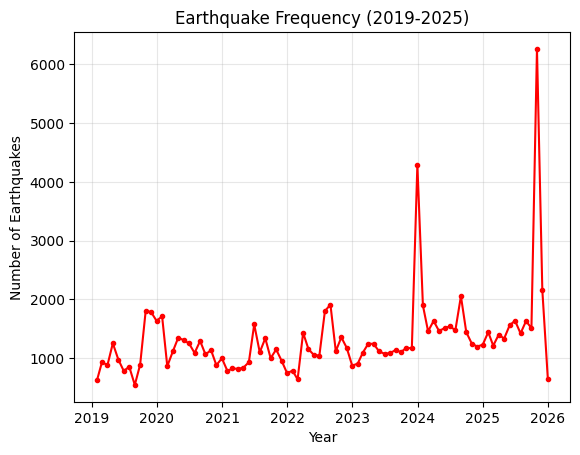

In [12]:
# Resample data by Month ('M') to see the volume over time
monthly_counts = df.set_index('Date_Time_PH').resample('ME').size()
plt.plot(monthly_counts.index, monthly_counts.values, color='red', marker='o', markersize=3)
plt.title('Earthquake Frequency (2019-2025)')
plt.ylabel('Number of Earthquakes')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)

### 3. Turn the date in Philippine time to Time in Day

In [13]:
# Date_Time_PH -> Time of Day
df['Date_Time_PH'] = pd.to_datetime(df['Date_Time_PH'])
df['Hour'] = df['Date_Time_PH'].dt.hour

def get_time_of_day(h):
    if 0 <= h < 6: return 'Time_Night'
    elif 6 <= h < 12: return 'Time_Morning'
    elif 12 <= h < 18: return 'Time_Afternoon'
    else: return 'Time_Evening'

df['Time_Bin'] = df['Hour'].apply(get_time_of_day)

### 4. Binning magnitude to categories (e.g., micro, minor, light, etc.)

In [14]:
'''
    Binning numerical data to categorical data
'''
# Magnitude -> Category
bins_mag = [0, 3, 4, 5, 6, 7, 10]
labels_mag = ['Magnitude_Micro', 'Magnitude_Minor', 'Magnitude_Light', 'Magnitude_Moderate', 'Magnitude_Strong', 'Magnitude_Major']
df['Magnitude_Bin'] = pd.cut(df['Magnitude'], bins=bins_mag, labels=labels_mag)


### 5. Binning depth to categories

In [15]:
'''
    Binning numerical data to categorical data. Convert Depth_In_Km first from object to int.
'''
# 1. Coerce errors to NaN
df["Depth_In_Km"] = pd.to_numeric(df["Depth_In_Km"], errors='coerce')

# 2. Drop rows where Depth is NaN
df = df.dropna(subset=["Depth_In_Km"])

# 3. Convert to integer
df["Depth_In_Km"] = df["Depth_In_Km"].astype('int64')

bins_depth = [0, 70, 300, 1000]
labels_depth = ['Depth_Shallow', 'Depth_Intermediate', 'Depth_Deep']
df['Depth_Bin'] = pd.cut(df['Depth_In_Km'], bins=bins_depth, labels=labels_depth)

### 6. Handling location bin

In [16]:
# D. Location (Using General_Location)
# We make it uppercase and remove whitespace to avoid "Davao " vs "Davao" mismatch
df['Location_Bin'] = df['General_Location'].str.upper().str.strip()

### 7. Create final basket for Apriori

In [17]:
# --- FINAL BASKET CREATION ---
# Create the transaction dataset with just the categorical columns
transactions = df[['Location_Bin', 'Time_Bin', 'Magnitude_Bin', 'Depth_Bin']].astype(str)

print("\nSample Transaction Data for Apriori:")
print(transactions.head())


Sample Transaction Data for Apriori:
         Location_Bin      Time_Bin    Magnitude_Bin           Depth_Bin
0      DAVAO ORIENTAL  Time_Morning  Magnitude_Minor       Depth_Shallow
1            SORSOGON  Time_Morning  Magnitude_Micro       Depth_Shallow
2      DAVAO ORIENTAL  Time_Morning  Magnitude_Light       Depth_Shallow
3                CEBU  Time_Morning  Magnitude_Micro       Depth_Shallow
4  OCCIDENTAL MINDORO  Time_Morning  Magnitude_Micro  Depth_Intermediate


In [18]:
transactions.head()

,Location_Bin,Time_Bin,Magnitude_Bin,Depth_Bin
0,DAVAO ORIENTAL,Time_Morning,Magnitude_Minor,Depth_Shallow
1,SORSOGON,Time_Morning,Magnitude_Micro,Depth_Shallow
2,DAVAO ORIENTAL,Time_Morning,Magnitude_Light,Depth_Shallow
3,CEBU,Time_Morning,Magnitude_Micro,Depth_Shallow
4,OCCIDENTAL MINDORO,Time_Morning,Magnitude_Micro,Depth_Intermediate


In [19]:
transactions.to_csv('binned_data.csv')

## Exploratory Data Analysis and Data Visualization (Binned Dataset)

In [20]:
earthquake_df = pd.read_csv("../dataset/binned_data.csv")

### 1. What are are top 20 most earthquake active locations in the Philippines?

From 2019 to 2025, we can see here that the province of Surigao del Sur is the province that experienced the most earthquakes, followed by Davao Oriental, then Surigao del Norte.

Text(0.5, 0, 'Count')

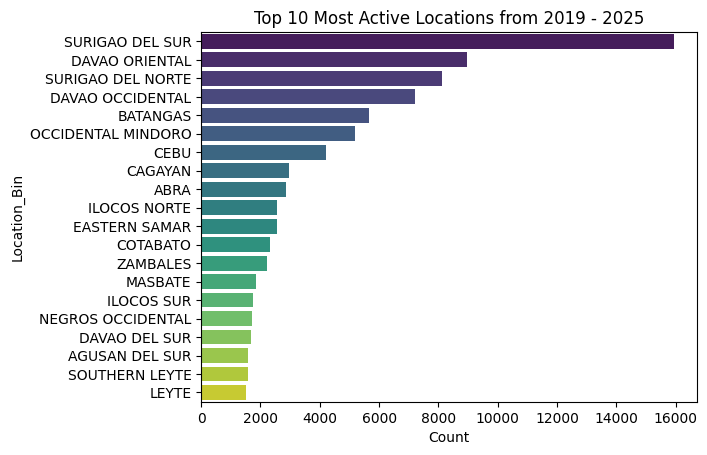

In [21]:
# Check the Top 10 Locations
top_locs = earthquake_df['Location_Bin'].value_counts().head(20)
sns.barplot(x=top_locs.values, y=top_locs.index, hue=top_locs.index, palette='viridis')
plt.title('Top 10 Most Active Locations from 2019 - 2025')
plt.xlabel('Count')

## 

### 2. Which combination of Depth and Magnitude types appear most frequently together?

Text(50.58159722222221, 0.5, 'Depth Class')

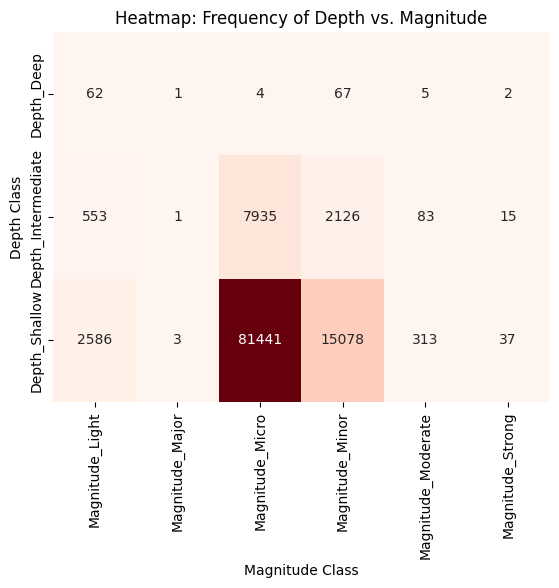

In [22]:
# Create a cross-tabulation (Count of overlaps)
ct_depth_mag = pd.crosstab(earthquake_df['Depth_Bin'], earthquake_df['Magnitude_Bin'])
# Plot Heatmap
sns.heatmap(ct_depth_mag, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Heatmap: Frequency of Depth vs. Magnitude')
plt.xlabel('Magnitude Class')
plt.ylabel('Depth Class')

## 3. Did we slice the data correctly?
### Suggestion: Apply new bins

We can see that fron the data binning earlier, one bin shows to dominate other bins in the Depth category, and that is the Depth_Shallow.

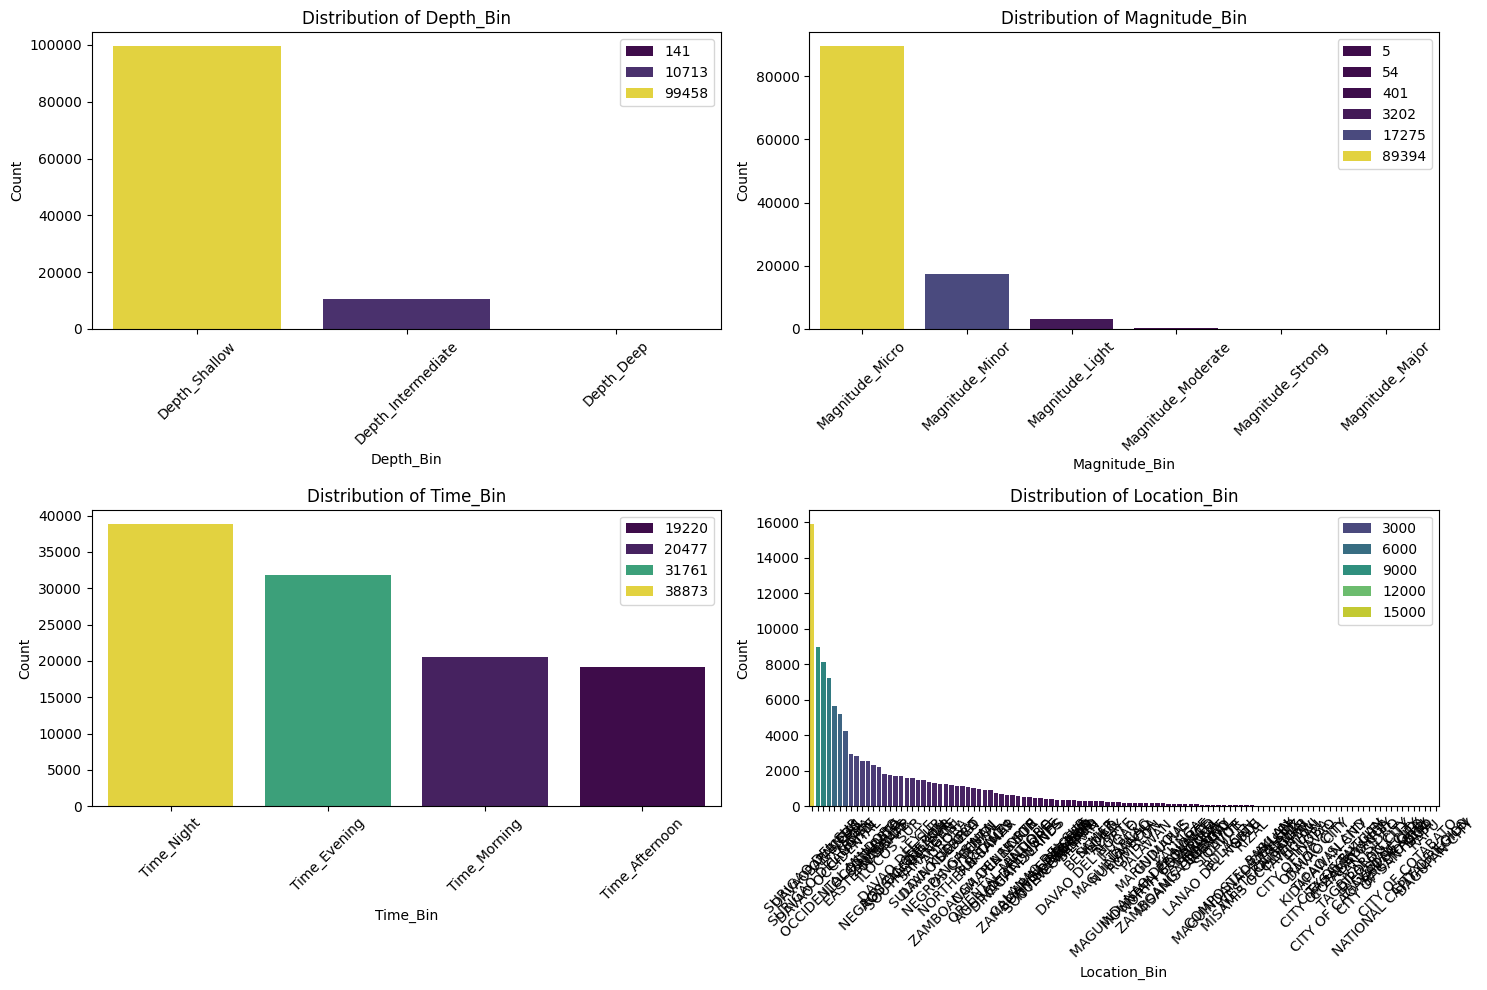

Depth Distribution (%):
Depth_Bin
Depth_Shallow         90.160635
Depth_Intermediate     9.711545
Depth_Deep             0.127819
Name: proportion, dtype: float64


In [23]:
'''
    We check the distribution of each bin to see which ones are dominant among others. This is to prevent boring/predictable association rules (everything will fall into one category).
'''

binned_cols = ['Depth_Bin', 'Magnitude_Bin', 'Time_Bin', 'Location_Bin']

# Create a figure with subplots
plt.figure(figsize=(15, 10))

for i, col in enumerate(binned_cols):
    plt.subplot(2, 2, i+1) # Create a grid of charts
    
    # Calculate counts
    counts = df[col].value_counts()
    
    # Plot bar chart
    sns.barplot(x=counts.index, y=counts.values, hue=counts.values, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45) # Rotate labels so they don't overlap

plt.tight_layout()
plt.show()

# Print exact percentages for precision
print("Depth Distribution (%):")
print(df['Depth_Bin'].value_counts(normalize=True) * 100  )


### Updating Depth Binning and Location Binning

In [24]:
'''
    Update depth binning
'''
bins_depth_new = [0, 15, 40, 120, 1000]
labels_depth_new = ['Depth_Surface', 'Depth_Crust', 'Depth_Interface', 'Depth_Deep']
earthquake_df['Depth_Bin'] = pd.cut(df['Depth_In_Km'], bins=bins_depth_new, labels=labels_depth_new, right=False)


'''
    Keep seismically active regions/provinces in the Philippines to avoid expanding dataset to 100+ columns and
      potentially producing bad association rules. We get the top 20 seismically active provinces in the Philippines.
'''

top_locations = earthquake_df['Location_Bin'].value_counts().head(20).index
print(top_locations)
# Replace everything else with 'OTHER'
earthquake_df['Location_Optimized'] = earthquake_df['Location_Bin'].apply(lambda x: x if x in top_locations else 'LOC_OTHER')

print(f"Original Unique Locations: {df['Location_Bin'].nunique()}")
print(f"Optimized Unique Locations: {earthquake_df['Location_Optimized'].nunique()}") 

Index(['SURIGAO DEL SUR', 'DAVAO ORIENTAL', 'SURIGAO DEL NORTE',
       'DAVAO OCCIDENTAL', 'BATANGAS', 'OCCIDENTAL MINDORO', 'CEBU', 'CAGAYAN',
       'ABRA', 'ILOCOS NORTE', 'EASTERN SAMAR', 'COTABATO', 'ZAMBALES',
       'MASBATE', 'ILOCOS SUR', 'NEGROS OCCIDENTAL', 'DAVAO DEL SUR',
       'AGUSAN DEL SUR', 'SOUTHERN LEYTE', 'LEYTE'],
      dtype='object', name='Location_Bin')
Original Unique Locations: 113
Optimized Unique Locations: 21


In [25]:
earthquake_df.head(5)

,Unnamed: 0,Location_Bin,Time_Bin,Magnitude_Bin,Depth_Bin,Location_Optimized
0,0,DAVAO ORIENTAL,Time_Morning,Magnitude_Minor,Depth_Crust,DAVAO ORIENTAL
1,1,SORSOGON,Time_Morning,Magnitude_Micro,Depth_Surface,LOC_OTHER
2,2,DAVAO ORIENTAL,Time_Morning,Magnitude_Light,Depth_Crust,DAVAO ORIENTAL
3,3,CEBU,Time_Morning,Magnitude_Micro,Depth_Crust,CEBU
4,4,OCCIDENTAL MINDORO,Time_Morning,Magnitude_Micro,Depth_Deep,OCCIDENTAL MINDORO


## Finalizing Columns

In [26]:
basket_df = earthquake_df[['Time_Bin', 'Depth_Bin', 'Magnitude_Bin', 'Location_Optimized']].astype(str)

print("Final Transaction Data:")
print(basket_df.head())

Final Transaction Data:
       Time_Bin      Depth_Bin    Magnitude_Bin  Location_Optimized
0  Time_Morning    Depth_Crust  Magnitude_Minor      DAVAO ORIENTAL
1  Time_Morning  Depth_Surface  Magnitude_Micro           LOC_OTHER
2  Time_Morning    Depth_Crust  Magnitude_Light      DAVAO ORIENTAL
3  Time_Morning    Depth_Crust  Magnitude_Micro                CEBU
4  Time_Morning     Depth_Deep  Magnitude_Micro  OCCIDENTAL MINDORO


In [27]:
basket_df.to_csv("../dataset/basket_data.csv")

In [37]:
sample_df = pd.read_csv("../dataset/basket_data.csv")

sample_df.head

<bound method NDFrame.head of         Unnamed: 0      Time_Bin      Depth_Bin    Magnitude_Bin  \
0                0  Time_Morning    Depth_Crust  Magnitude_Minor   
1                1  Time_Morning  Depth_Surface  Magnitude_Micro   
2                2  Time_Morning    Depth_Crust  Magnitude_Light   
3                3  Time_Morning    Depth_Crust  Magnitude_Micro   
4                4  Time_Morning     Depth_Deep  Magnitude_Micro   
...            ...           ...            ...              ...   
110326      110326    Time_Night    Depth_Crust  Magnitude_Micro   
110327      110327    Time_Night    Depth_Crust  Magnitude_Micro   
110328      110328    Time_Night    Depth_Crust  Magnitude_Micro   
110329      110329    Time_Night    Depth_Crust  Magnitude_Micro   
110330      110330    Time_Night    Depth_Crust  Magnitude_Micro   

        Location_Optimized  
0           DAVAO ORIENTAL  
1                LOC_OTHER  
2           DAVAO ORIENTAL  
3                     CEBU  
4       

## One-Hot Encoding Categorical Features

In [38]:
from mlxtend.preprocessing import TransactionEncoder

# Reimport basket values dataset
basket_data = pd.read_csv("../dataset/basket_data.csv")

# OPTIONAL: Drop the index column if it exists (e.g., 'Unnamed: 0')
if 'Unnamed: 0' in basket_data.columns:
    basket_data = basket_data.drop(columns=['Unnamed: 0'])

# Convert to List of Lists
transactions = basket_data.astype(str).values.tolist()

# Instantiate and fit the encoder
encoder = TransactionEncoder()
onehot_matrix = encoder.fit(transactions).transform(transactions)

# Convert back to DataFrame (The "Apriori Ready" format)
df_encoded = pd.DataFrame(onehot_matrix, columns=encoder.columns_)

# Check the shape: (Number of Earthquakes, Number of Unique Items)
print(f"Matrix Shape: {df_encoded.shape}")
print(df_encoded.head())

Matrix Shape: (110331, 36)
    ABRA  AGUSAN DEL SUR  BATANGAS  CAGAYAN   CEBU  COTABATO  DAVAO DEL SUR  \
0  False           False     False    False  False     False          False   
1  False           False     False    False  False     False          False   
2  False           False     False    False  False     False          False   
3  False           False     False    False   True     False          False   
4  False           False     False    False  False     False          False   

   DAVAO OCCIDENTAL  DAVAO ORIENTAL  Depth_Crust  ...  OCCIDENTAL MINDORO  \
0             False            True         True  ...               False   
1             False           False        False  ...               False   
2             False            True         True  ...               False   
3             False           False         True  ...               False   
4             False           False        False  ...                True   

   SOUTHERN LEYTE  SURIGAO DEL NORT

## Implementing Apriori and Generating Rules (Sorted by highest lifts/strong association)

In [53]:
from mlxtend.frequent_patterns import apriori, association_rules

# Mine Frequent Itemsets
# min_support=0.01 means the pattern must appear in at least 1% of the data
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Generate Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

# Sort by Lift (Strength of Association)
rules = rules.sort_values('lift', ascending=False)

# Display the Top 10 Rules
print("\nAssociation Rules:\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))




# Convert frozensets to strings 
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Export to CSV
final_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']
# Create the clean dataframe
apriori_rules = rules[final_cols]
apriori_rules.to_csv("apriori_association_rules.csv", index=False)
print(f"Successfully generated {len(apriori_rules)} rules. Saved to 'apriori_association_rules.csv'.")

# Display Stats
print(f"\nHighest Lift: {apriori_rules['lift'].max()}")
print(f"Lowest Lift: {apriori_rules['lift'].min()}")


Association Rules:
                          antecedents                       consequents  \
46    (Depth_Crust, Magnitude_Minor)                (DAVAO OCCIDENTAL)   
49                (DAVAO OCCIDENTAL)    (Depth_Crust, Magnitude_Minor)   
16                 (Magnitude_Minor)                (DAVAO OCCIDENTAL)   
17                (DAVAO OCCIDENTAL)                 (Magnitude_Minor)   
48                 (Magnitude_Minor)   (Depth_Crust, DAVAO OCCIDENTAL)   
47   (Depth_Crust, DAVAO OCCIDENTAL)                 (Magnitude_Minor)   
36  (Depth_Surface, Magnitude_Micro)                            (CEBU)   
39                            (CEBU)  (Depth_Surface, Magnitude_Micro)   
19                 (Magnitude_Minor)                  (DAVAO ORIENTAL)   
18                  (DAVAO ORIENTAL)                 (Magnitude_Minor)   

     support  confidence      lift  
46  0.012553    0.174302  2.661711  
49  0.012553    0.191696  2.661711  
16  0.026928    0.171983  2.626300  
17  0.026928    

## Sort by Highest Confidence

In [51]:
# Sort by Lift (Strength of Association)
rules = rules.sort_values('confidence', ascending=False)

# Display the Top 10 Rules
print("\nAssociation Rules:\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Association Rules:
                        antecedents      consequents   support  confidence  \
34               CEBU, Depth_Crust  Magnitude_Micro  0.014964    0.980404   
26           BATANGAS, Depth_Crust  Magnitude_Micro  0.021046    0.919968   
32            BATANGAS, Time_Night  Magnitude_Micro  0.015879    0.918721   
30          BATANGAS, Time_Evening  Magnitude_Micro  0.012698    0.915088   
6                         BATANGAS  Magnitude_Micro  0.046868    0.913604   
4                   AGUSAN DEL SUR  Magnitude_Micro  0.013079    0.910410   
12                            CEBU  Magnitude_Micro  0.034677    0.907065   
28         BATANGAS, Depth_Surface  Magnitude_Micro  0.016369    0.904357   
2                             ABRA  Magnitude_Micro  0.023185    0.898805   
64  Time_Night, OCCIDENTAL MINDORO  Magnitude_Micro  0.014946    0.896683   

        lift  
34  1.210025  
26  1.135434  
32  1.133894  
30  1.129411  
6   1.127580  
4   1.123638  
12  1.119509  
28  1.11616

## Sort by Highest Support

In [52]:
# Sort by Lift (Strength of Association)
rules = rules.sort_values('support', ascending=False)

# Display the Top 10 Rules
print("\nAssociation Rules:\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Association Rules:
                      antecedents                   consequents   support  \
63                     LOC_OTHER   Time_Night, Magnitude_Micro  0.081274   
62   Time_Night, Magnitude_Micro                     LOC_OTHER  0.081274   
7                Magnitude_Micro                      BATANGAS  0.046868   
6                       BATANGAS               Magnitude_Micro  0.046868   
13               Magnitude_Micro                          CEBU  0.034677   
12                          CEBU               Magnitude_Micro  0.034677   
50  Depth_Crust, Magnitude_Micro             SURIGAO DEL NORTE  0.031251   
51             SURIGAO DEL NORTE  Depth_Crust, Magnitude_Micro  0.031251   
78      Depth_Surface, LOC_OTHER   Time_Night, Magnitude_Micro  0.030327   
79   Time_Night, Magnitude_Micro      Depth_Surface, LOC_OTHER  0.030327   

    confidence      lift  
63    0.320811  1.103109  
62    0.279459  1.103109  
7     0.057845  1.127580  
6     0.913604  1.127580  
13    0

## Visualizing generated rules

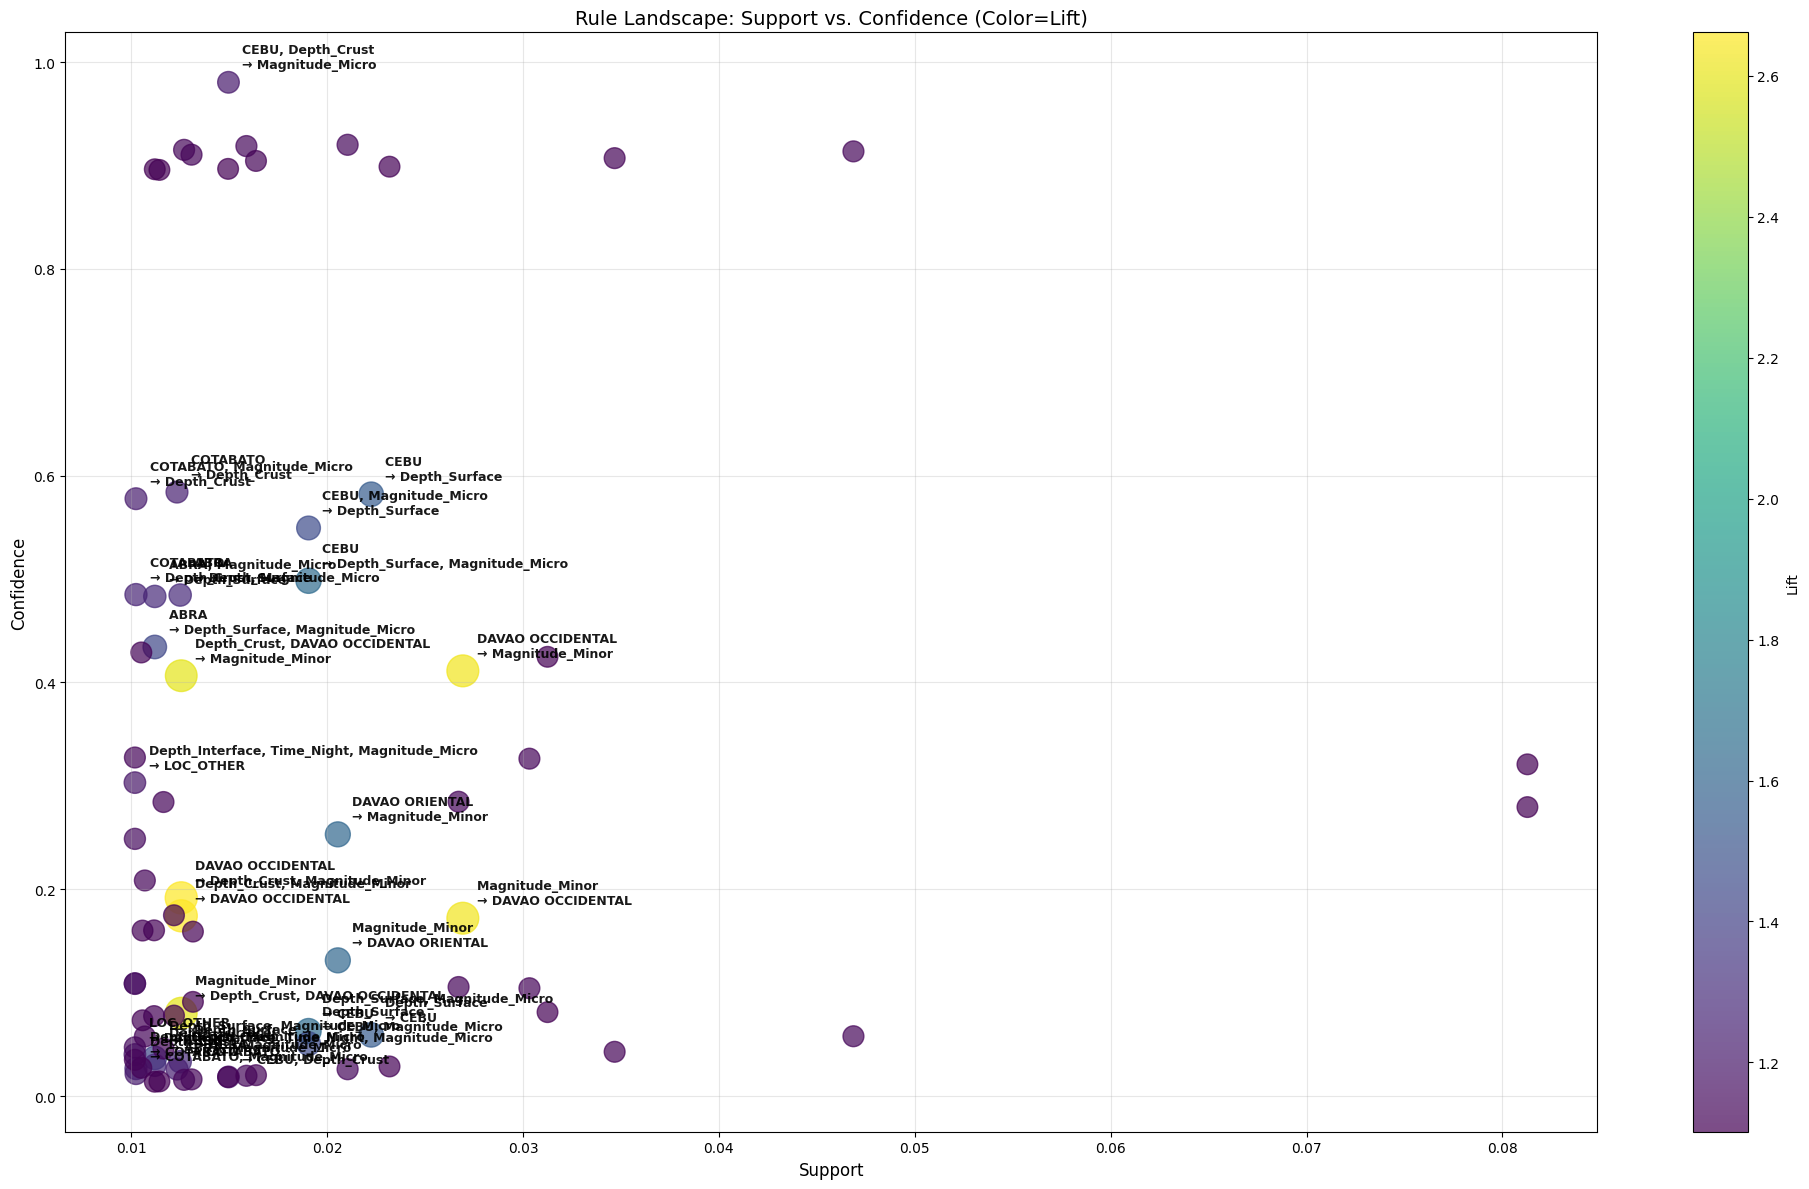

In [ ]:
# Set the figure size (width=20 inches, height=12 inches)
fig, ax = plt.subplots(figsize=(20, 12))

scatter = ax.scatter(
    x=rules["support"],
    y=rules["confidence"],
    c=rules["lift"],
    cmap="viridis",
    s=rules["lift"] * 200,  # Increased multiplier for bigger dots
    alpha=0.7
)


# Get top 30 rules by lift for labeling
top_30_rules = rules.nlargest(30, 'lift')

for idx, row in top_30_rules.iterrows():
    ax.annotate(
        f"{row['antecedents']} \n→ {row['consequents']}", 
        xy=(row['support'], row['confidence']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        color='black',
        fontweight='bold',
        alpha=0.9
    )

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title("Rule Landscape: Support vs. Confidence (Color=Lift)", fontsize=14)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Lift')

plt.tight_layout()
plt.show()

## Observation from First Apriori Rule Mining Implementation
### In this section we are going to discuss the implications of some of the generated rules of the Apriori algorithm to the Philippine Earthquake Dataset.

* On row 36, the rule {Depth_Surface, Magnitude_Micro} -> {CEBU} has a lift of Lift: 1.64. Cebu is strongly associated with surface-deep and micro magnitude earthquakes. 

* Additonally, a rule with high confidence (98%) associated Cebu with Depth_crust and micro_magnitude. This is followed by the 91% confidence of Batangas and Depth_Crust associated with micro magnitudes.

* Analysis: When compared to provinces like Surigao del Sur and Davao Occidental, Cebu does not sit near a subduction trench (Philippine Trench). The seismic activity in the place is driven by the Cebu Fault System, which runs through the island's crust. For Batangas, it is situated near Lubang Fault, which lies between Mindoro Island and Batangas. Then we have the Batangas Bay Fault System and the Taal Volcano.

* Insight: The Apriori algorithm correctly produced a rule that identified Cebu as a "Crustal Source Zone", described by (<15km) earthquake events. It implies that seismic risk in Cebu is localized to that area and is dominated with very small earthquakes. Strong earthquakes are extremely rare and can be considered as statisical anomalies, evident by recent earthquakes in City of Bogo. We can deduce that Batangas is also dominated by swarms of very small earthquakes--with 91% chance of these earthquakes having magnitude 0 to 3--rather than large earthquakes.


------------------------------------------------------------------------------------------------------------
* The rule {Depth_Crust (15-40km), Magnitude_Minor (Magnitude 3-4)} ->  {DAVAO OCCIDENTAL} has a lift of Lift: 2.6617 (highest lift/association) and confidence of 17%

* Analysis: The subducting Philippine Sea Plate dives beneath Mindanao, creating earthquakes at varying depths (Interface and Deep). The algorithm picks this up as a "mixed" or "deeper" signal compared to Cebu. To add, the algorithm has detected that earthquakes in Davao Occidental tend to occur in the Lower Crust which is 15–40 km deep.

* Insight: The provinces in Eastern Mindanao, Surigao del Sur and Davao Occidental, exhibits a complex 'Trench Signature,' distinguishing it from the purely crustal regime of the Visayas. This is due to its proximity to the Philippine Trench and it lies on the Philippine Fault System. If an earthquake happens in Davao Occidental, it is 2.6x more likely to be a "Minor" earthquake than the national average.


----------------------------------------------------------------------------------------------


* As for the rule: {SURIGAO DEL SUR} → {Mag_Micro} (most active area) has Confidence: 82% (Very High Reliability) with Lift: 1.01 (Near Random/Baseline)

* Analysis: Surigao is not "special"; it is "dominant." Because the 2023 swarm produced so many thousands of earthquakes, Surigao's behavior (Shallow + Micro) effectively defined the national average.

* Insight: The dataset confirms that the 2023-2025 Surigao Del Sur Swarm was characterized by high-frequency, low-magnitude surface energy release. The low Lift (1.01) indicates that this swarm behavior statistically overwhelmed the dataset, becoming the 'standard' profile for Philippine seismicity during this period.


----------------------------------------------------------------------------------------------

* Rule: {DAVAO ORIENTAL} -> {Magnitude_Minor} with Lift: 1.61

* Analysis: Similar to Davao Occidental, Davao Oriental shows a Lift > 1.6 for Minor earthquakes.

* Insight: Both provinces (Occidental and Oriental) share a similarity when it comes to seismic events, they are the only two regions in the top rules that strongly predict Magnitude_Minor events. Thus proving that proximity to the Philippine Trench and on active fault lines creates a distinct, higher-energy earthquake profile compared to the rest of the country.
